# Libraries

In [1]:
!pip install pytorch-lightning

In [2]:
%matplotlib inline

import numpy as np
import torch
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms

# MNIST Data Module

In [3]:
# number of subprocesses to use for data loading
NUM_WORKER = 0
# how many samples per batch to load
BATCH_SIZE = 64



In [4]:
class MNISTDataModule(LightningDataModule):
  def __init__(self, data_dir = 'data', batch_size = BATCH_SIZE, num_workers = NUM_WORKER):
    super().__init__()
    self.data_dir = data_dir
    self.batch_size = batch_size
    self.num_workers = num_workers
    # convert data to torch.FloatTensor
    self.transform = transforms.ToTensor()
  def prepare_data(self):
    self.mnist_train = datasets.MNIST(self.data_dir, train=True, download=True, transform=self.transform)
  def train_dataloader(self):
    return torch.utils.data.DataLoader(self.mnist_train, batch_size=self.batch_size,
                                       num_workers = self.num_workers)

# GAN Model

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Discriminator $D$

In [6]:
class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        
        # define all layers

        # define hidden fully-connected linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)
        
        
    def forward(self, x):
        
        # flatten image
        x = x.view(-1, 28*28)
        
        # pass x through all hidden layers
        # apply leaky relu activation to all hidden layers
        
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer
        out = self.fc4(x)

        return out

# Generator D

In [7]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        
        # define all layers

        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        # dropout layer 
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        
        # pass x through all layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer should have tanh applied
        out = F.tanh(self.fc4(x))

        return out

# Hyper params

In [8]:
# Size of images
input_size = 784
# Hidden layers 'basic' size
hidden_size = 64

# Discriminator hyperparams
# Size of discriminator output (real or fake)
d_output_size = 1

# Generator hyperparams

# Size of latent vector to give to generator
z_size = 100


In [9]:
criterion = nn.BCEWithLogitsLoss()
samples = []
losses = []

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [11]:
class GAN(LightningModule):
  def __init__(self,
               img_size: int = 784,
               z_size: int = 100,
               hidden_dim: int = 64,
               lr : float = 0.0002,
               **kwargs):
    super().__init__()
    self.save_hyperparameters()

    self.D = Discriminator(input_size = img_size, hidden_dim=hidden_dim, output_size=1).to(device)
    self.G = Generator(input_size = z_size,hidden_dim=hidden_dim, output_size=img_size)
    sample_size = 16
    self.fixed_z = torch.randn((sample_size, z_size)).to(device)
  def forward(self, z):
    return self.G(z)
  
  # def real_loss(D_out, smooth=False):
  #   # compare logits to real labels
  #   # smooth labels if smooth=True
    
  #   batch_size = D_out.size(0)
  #   # label smoothing
  #   if smooth:
  #       # smooth, real labels = 0.9
  #       labels = torch.ones(batch_size)*0.9
  #   else:
  #       labels = torch.ones(batch_size) # real labels = 1
        
  #   # numerically stable loss
  #   criterion = nn.BCEWithLogitsLoss()
  #   # calculate loss
  #   loss = criterion(D_out.squeeze(), labels)
  #   return loss

  # def fake_loss(D_out):
  #   batch_size = D_out.size(0)
  #   labels = torch.zeros(batch_size) # fake labels = 0
  #   criterion = nn.BCEWithLogitsLoss()
  #   # calculate loss
  #   loss = criterion(D_out.squeeze(), labels)
  #   return loss
  
  def training_step(self, batch, batch_idx, optimizer_idx):
    real_images, _ = batch
    batch_size = real_images.shape[0]
    ## Important rescaling step ## 
    real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)
    
    ## Sample noise ##
    z = torch.randn((batch_size, self.hparams.z_size)).to(device)
  
    # Training Generator
    if optimizer_idx == 0:
      fake_images = self.G(z)

      # Real Label & Label smoothing
      real_labels = torch.ones(batch_size).to(device)
      real_labels = real_labels * 0.9

      D_fake = self.D(fake_images)
      g_loss = criterion(D_fake.squeeze(), real_labels) # use real loss to flip labels
      
      self.g_loss = g_loss.item()
      return g_loss
    
    # Training Discriminator
    if optimizer_idx == 1:
      
      # Fake Label / Real Label & Label smoothing 
      real_labels = torch.ones(batch_size).to(device)
      real_labels = real_labels * 0.9
      fake_labels = torch.zeros(batch_size).to(device)

      # Training with real imgs
      D_real = self.D(real_images)
      d_real_loss = criterion(D_real.squeeze(), real_labels)
      
      #  Training with fake imgs
      fake_images = self.G(z)
      D_fake = self.D(fake_images)
      d_fake_loss = criterion(D_fake.squeeze(), fake_labels)

      # Combine loss
      d_loss = d_real_loss + d_fake_loss

      self.d_loss = d_loss.item()
      return d_loss
  def configure_optimizers(self):
    lr = self.hparams.lr

    g_optimizer = torch.optim.Adam(self.G.parameters(), lr=lr)
    d_optimizer = torch.optim.Adam(self.D.parameters(), lr=lr)
    return [g_optimizer, d_optimizer], []
  def on_epoch_end(self):
    losses.append((self.d_loss, self.g_loss))
    # Log sampled images
    self.G.eval()
    sample_imgs = self.G(self.fixed_z)
    samples.append(sample_imgs)
    self.G.train()


In [12]:
dm = MNISTDataModule()
model = GAN()
trainer = Trainer(max_epochs=30, progress_bar_refresh_rate=20, gpus=1)
trainer.fit(model, dm)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type          | Params
---------------------------------------
0 | D    | Discriminator | 242 K 
1 | G    | Generator     | 249 K 
---------------------------------------
491 K     Trainable params
0         Non-trainable params
491 K     Total params
1.966     Total estimated

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


# Training Loss

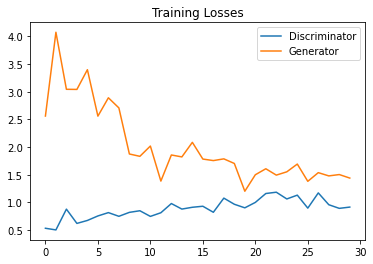

In [13]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

In [14]:
# Save training generator samples
import pickle as pkl
with open('train_samples_PL.pkl', 'wb') as f:
    pkl.dump(samples, f)

# Generator samples from training

In [18]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [19]:
# Load samples from generator, taken while training
with open('train_samples_PL.pkl', 'rb') as f:
    samples = pkl.load(f)

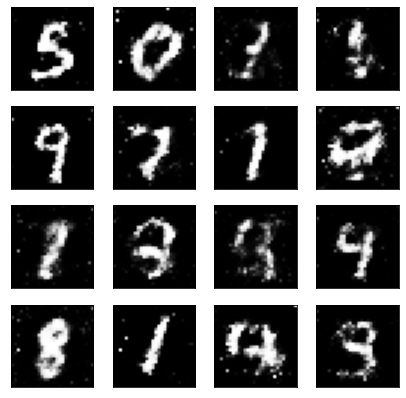

In [20]:
# -1 indicates final epoch's samples (the last in the list)
view_samples(-1, samples)

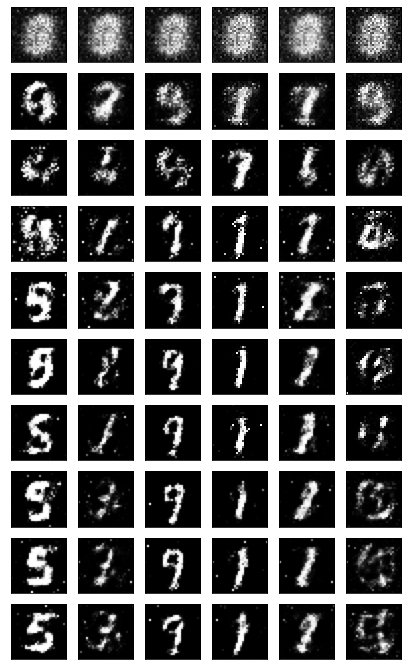

In [22]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach().cpu()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

# Sampling from $G$

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


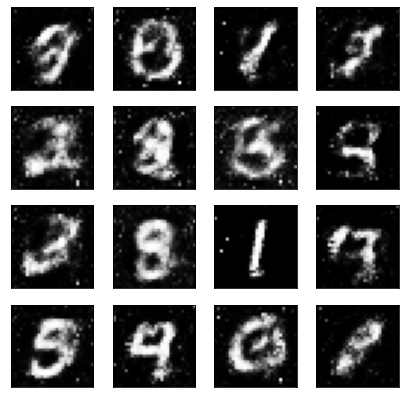

In [26]:
# randomly generated, new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

model.eval() # eval mode
# generated samples
rand_images = model(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])